In [1]:
import numpy as np
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from eeg_emg_load import load_emg_eeg_data, butter_bandpass_filter, epoch, plot_epochs
from model_utils import train_LDA, train_RFs, train_SVM, train_HTNet, fold_split_data, balance_data

In [2]:
if os.environ.get("CUDA_VISIBLE_DEVICES") is None:
    #Choose GPU 0 as a default if not specified (can set this in Python script that calls this)
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Load in the EEG and EMG data

In [3]:
path = '/data1/users/zsteineh/EE560';

eeg_folder = 'EEG'
eeg_file = 'EEG_session1_sub1_multigrasp_realMove.mat'

emg_folder = 'EMG'
emg_file = 'EMG_session1_sub1_multigrasp_realMove.mat'

# Load data in
emg_data, emg_fs, emg_event_times, emg_grasp_labels, emg_grasp_names = load_emg_eeg_data(os.path.join(path,emg_folder, emg_file));
eeg_data, eeg_fs, eeg_event_times, eeg_grasp_labels, eeg_grasp_names = load_emg_eeg_data(os.path.join(path,eeg_folder, eeg_file));

In [4]:
emg_data = butter_bandpass_filter(emg_data, 8, 30, emg_fs, order=5)
eeg_data = butter_bandpass_filter(eeg_data, 8, 30, emg_fs, order=5)

In [5]:
emg_epochs = epoch(emg_data,emg_event_times, emg_fs, 1);
eeg_epochs = epoch(eeg_data,eeg_event_times, eeg_fs, 1);

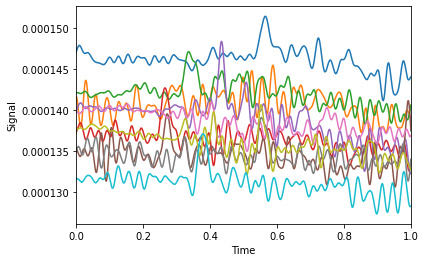

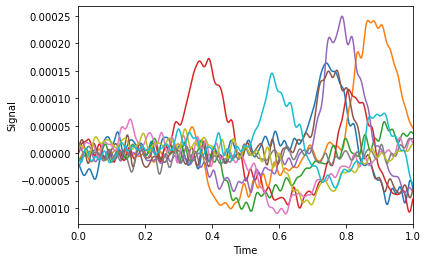

In [6]:
plot_epochs(emg_epochs, emg_fs, 1, 10) # First number is number of channels, Second number is number of epochs
plot_epochs(eeg_epochs, eeg_fs, 1, 10) # First number is number of channels, Second number is number of epochs

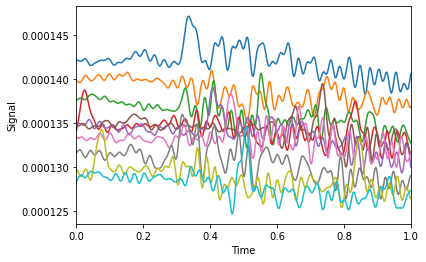

In [7]:
" Now let's see if we can plot the subset for a specified label"
plot_epochs(emg_epochs[:,:,emg_grasp_labels == 3], emg_fs, 1, 10)

In [8]:
# samples, channels, num events
emg_epochs.shape

(2500, 7, 300)

In [9]:
eeg_grasp_names = [i[0] for i in eeg_grasp_names]
eeg_grasp_names

['Cylindrical', 'Spherical', 'Lumbrical', 'Rest']

In [10]:
np.all(emg_grasp_labels == eeg_grasp_labels)

True

In [11]:
trimmed_grasp_labels, trimmed_emg_epochs, trimmed_eeg_epochs = balance_data(emg_grasp_labels, emg_epochs, eeg_epochs)

[2. 3. 1. 3. 3. 4. 2. 3. 4. 2. 4. 2. 4. 1. 4. 3. 3. 1. 1. 4. 2. 1. 3. 2.
 1. 1. 4. 2. 2. 4. 1. 4. 1. 4. 3. 3. 2. 3. 1. 4. 3. 3. 3. 2. 1. 3. 2. 2.
 1. 4. 3. 4. 3. 1. 1. 4. 1. 2. 4. 1. 2. 4. 1. 4. 3. 1. 4. 3. 1. 4. 3. 3.
 1. 4. 3. 3. 4. 3. 2. 4. 1. 2. 4. 1. 1. 2. 2. 3. 4. 1. 1. 1. 2. 2. 3. 4.
 1. 1. 1. 2. 2. 2. 4. 3. 1. 3. 2. 2. 1. 3. 3. 4. 2. 1. 4. 3. 4. 3. 4. 1.
 3. 4. 3. 2. 3. 4. 2. 3. 1. 4. 2. 3. 4. 2. 2. 2. 1. 1. 1. 2. 2. 3. 3. 3.
 1. 1. 4. 1. 3. 4. 2. 2. 1. 1. 4. 1. 4. 2. 4. 2. 2. 3. 3. 4. 3. 2. 3. 2.
 2. 1. 1. 4. 3. 2. 2. 4. 1. 4. 2. 3. 4. 2. 4. 2. 3. 2. 4. 1. 2. 4. 2. 4.
 1. 3. 1. 3. 4. 1. 4. 3.]
(2500, 7, 200)
(2500, 7, 200)
(array([1., 2., 3., 4.]), array([50, 50, 50, 50]))


Still need code for pulliing out the CSP features

# Classify with just EEG data
... for now

In [ ]:
folds = 10
cur_channel = 2
fold_accs = train_LDA(folds, cur_channel, eeg_epochs, eeg_grasp_labels, eeg_grasp_names)

note to self: do I need to make sure that classes are balanced in both datasets?

In [ ]:
plt.boxplot(np.array(fold_accs), labels=['Train', 'Test'])
plt.ylabel('Classification Accuracy')
plt.ylim((0,1))
plt.axhline((100/len(eeg_grasp_names))/100,c='k',linestyle='--')
plt.title('Classification Accuracy with LDA on one EEG channel')
plt.show()

# Classify EMG with LDA

In [ ]:
folds = 10
cur_channel = 2

fold_accs = train_LDA(folds, cur_channel, emg_epochs, emg_grasp_labels, eeg_grasp_names)

In [ ]:
plt.boxplot(np.array(fold_accs), labels=['Train', 'Test'])
plt.ylabel('Classification Accuracy')
plt.ylim((0,1))
plt.axhline((100/len(eeg_grasp_names))/100,c='k',linestyle='--')
plt.title('Classification Accuracy with LDA on one EMG channel')
plt.show()

# Next will try with both EMG and EEG together

In [ ]:
folds = 10
cur_channel = 0

emg_eeg_epochs = np.concatenate( (emg_epochs[:,cur_channel,:], eeg_epochs[:,cur_channel,:]), axis=0 )
emg_eeg_epochs = np.expand_dims(emg_eeg_epochs, axis = 1)

fold_accs = train_LDA(folds, cur_channel, emg_eeg_epochs, emg_grasp_labels, eeg_grasp_names)

In [ ]:
plt.boxplot(np.array(fold_accs), labels=['Train', 'Test'])
plt.ylabel('Classification Accuracy')
plt.ylim((0,1))
plt.axhline((100/len(eeg_grasp_names))/100,c='k',linestyle='--')
plt.title('Classification Accuracy with LDA on one EMG and EEG channel')
plt.show()

# Now trying Classification with RFs

In [ ]:
folds = 10
cur_channel = 2

fold_accs = train_RFs(folds, cur_channel, emg_epochs, emg_grasp_labels, eeg_grasp_names)

Unbalanced with Rest data really messing with the RF model

In [ ]:
plt.boxplot(np.array(fold_accs), labels=['Train', 'Test'])
plt.ylabel('Classification Accuracy')
plt.ylim((0,1))
plt.axhline((100/len(eeg_grasp_names))/100,c='k',linestyle='--')
plt.title('Classification Accuracy with RFs on one EMG channel')
plt.show()

In [ ]:
np.unique(emg_grasp_labels, return_counts = True)

In [ ]:
folds = 10
cur_channel = 6

fold_accs = train_RFs(folds, cur_channel, trimmed_emg_epochs, trimmed_grasp_labels, eeg_grasp_names)

In [ ]:
plt.boxplot(np.array(fold_accs), labels=['Train', 'Test'])
plt.ylabel('Classification Accuracy')
plt.ylim((0,1))
plt.axhline((100/len(eeg_grasp_names))/100,c='k',linestyle='--')
plt.title('Classification Accuracy with RFs on one EMG channel')
plt.show()

Not doing so well, but I'm guessing this could be because of the reading from one channel

In [ ]:
folds = 10
cur_channel = 0

fold_accs = train_RFs(folds, cur_channel, trimmed_eeg_epochs, trimmed_grasp_labels, eeg_grasp_names)

In [ ]:
plt.boxplot(np.array(fold_accs), labels=['Train', 'Test'])
plt.ylabel('Classification Accuracy')
plt.ylim((0,1))
plt.axhline((100/len(eeg_grasp_names))/100,c='k',linestyle='--')
plt.title('Classification Accuracy with RFs on one EEG channel')
plt.show()

# Trying with SVM

In [ ]:
folds = 10
cur_channel = 0

fold_accs = train_SVM(folds, cur_channel, trimmed_eeg_epochs, trimmed_grasp_labels, eeg_grasp_names)
plt.boxplot(np.array(fold_accs), labels=['Train', 'Test'])
plt.ylabel('Classification Accuracy')
plt.ylim((0,1))
plt.axhline((100/len(eeg_grasp_names))/100,c='k',linestyle='--')
plt.title('Classification Accuracy with SVM on one EEG channel')
plt.show()

# Train with HTNet

In [12]:
folds = 10
cur_channel = 0

fold_accs = train_HTNet(folds, trimmed_eeg_epochs, trimmed_grasp_labels, eeg_grasp_names, eeg_fs)
plt.boxplot(np.array(fold_accs), labels=['Train', 'Test'])
plt.ylabel('Classification Accuracy')
plt.ylim((0,1))
plt.axhline((100/len(eeg_grasp_names))/100,c='k',linestyle='--')
plt.title('Classification Accuracy with HTNet on EEG data')
plt.show()

Making model 

Model made

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 60, 2500)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 60, 2500)       512       
_________________________________________________________________
lambda (Lambda)              (None, 8, 60, 2500)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 60, 2500)       32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 1, 2500)       960       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 1, 2500)       64        
_________________________________________________________________
activation (Activation)      (None

/home/zsteineh/anaconda3/envs/ECoGDL_venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsteineh/anaconda3/envs/ECoGDL_venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2 2 2 2 2 2 2 2 2 2 2 1 0 2 0 2 3 2 2 2 2 1 2 2 2 2 0 2 1 1 3 3 2 2 2 2 2
 3 2 3 2 2 2 2 2 2 0 2 3 0 3 2 3 0 3 2 0 1 2 2 2 3 2 3 2 2 0 3 2 3 1 2 3 2
 2 2 2 2 0 2 2 2 2 2 3 3 3 2 2 2 3 2 3 3 2 1 3 2 2 2 1 2 2 2 2 2 2 1 2 2 2
 2 2 1 2 1 2 3 2 2 3 0 1 2 3 2 2 2 2 0 2 2 2 1 2 2 2 2 0 2 2 3 2 3 2 2 2 2
 2 3 2 2 2 2 0 2 0 2 1 2 3 2 3 2 1 2 2 2 0 2 2 2 2 2 3 2 2 2 2 2]
training accuracy before training is: 0.23333333333333334
Epoch 1/50
12/12 - 0s - loss: 1.3593 - accuracy: 0.3444
Epoch 2/50
12/12 - 0s - loss: 1.1195 - accuracy: 0.5444
Epoch 3/50
12/12 - 0s - loss: 1.0068 - accuracy: 0.5889
Epoch 4/50
12/12 - 0s - loss: 0.9231 - accuracy: 0.7000
Epoch 5/50
12/12 - 0s - loss: 0.8933 - accuracy: 0.6944
Epoch 6/50
12/12 - 0s - loss: 0.8551 - accuracy: 0.6667
Epoch 7/50
12/12 - 0s - loss: 0.8146 - accuracy: 0.6778
Epoch 8/50
12/12 - 0s - loss: 0.7910 - accuracy: 0.7278
Epoch 9/50
12/12 - 0s - loss: 0.7719 - accuracy: 0.7444
Epoch 10/50
12/12 - 0s - loss: 0.7466 - accuracy: 0.7389
Epoch 11/50
12/

Epoch 8/50
12/12 - 0s - loss: 0.7488 - accuracy: 0.7833
Epoch 9/50
12/12 - 0s - loss: 0.7472 - accuracy: 0.7667
Epoch 10/50
12/12 - 0s - loss: 0.7129 - accuracy: 0.7722
Epoch 11/50
12/12 - 0s - loss: 0.7029 - accuracy: 0.7778
Epoch 12/50
12/12 - 0s - loss: 0.6934 - accuracy: 0.8000
Epoch 13/50
12/12 - 0s - loss: 0.7176 - accuracy: 0.7833
Epoch 14/50
12/12 - 0s - loss: 0.7092 - accuracy: 0.7833
Epoch 15/50
12/12 - 0s - loss: 0.7092 - accuracy: 0.7778
Epoch 16/50
12/12 - 0s - loss: 0.7085 - accuracy: 0.7833
Epoch 17/50
12/12 - 0s - loss: 0.6734 - accuracy: 0.8333
Epoch 18/50
12/12 - 0s - loss: 0.6737 - accuracy: 0.8000
Epoch 19/50
12/12 - 0s - loss: 0.6539 - accuracy: 0.8000
Epoch 20/50
12/12 - 0s - loss: 0.6642 - accuracy: 0.8056
Epoch 21/50
12/12 - 0s - loss: 0.6357 - accuracy: 0.8333
Epoch 22/50
12/12 - 0s - loss: 0.6654 - accuracy: 0.8167
Epoch 23/50
12/12 - 0s - loss: 0.6407 - accuracy: 0.8222
Epoch 24/50
12/12 - 0s - loss: 0.6419 - accuracy: 0.8222
Epoch 25/50
12/12 - 0s - loss: 0.

KeyboardInterrupt: 